In [2]:
%load_ext autoreload
%autoreload 2

import os 
# os.environ['R_HOME']= r'C:\Users\tomha\miniconda3\envs\octagon_analysis\lib\R'
os.environ['R_HOME']= r'D:\Users\Tom\miniconda3\envs\octagon_analysis\lib\R'
# os.environ['R_HOME']= '/home/tom/miniconda3/envs/octagon_analysis/lib/R'

import rpy2

import rpy2.robjects as robjects
print(robjects.r('R.version.string'))

import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import globals
import data_strings
import data_extraction.get_indices as get_indices
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
from trajectory_analysis import trajectory_vectors
from plotting import plot_octagon
import parse_data.identify_filepaths as identify_filepaths 
from data_extraction.trial_list_filters import filter_trials_other_visible
from analysis import opponent_visibility
from ipywidgets import IntProgress
from IPython.display import display
import time
from pymer4.models import Lmer


[1] "R version 4.1.3 (2022-03-10)"



In [75]:
os.getcwd()

'd:\\Tom\\Documents\\SWC\\repos\\octagon_analysis\\sandbox\\glm'

## Solos

In [154]:
# load solo data from left-one-out cross-validation
data_folder = os.path.join('..','data', 'k_fold_CV', '3levels-firstseenwall')

CV_dataset_names = [
    file for file in os.listdir(data_folder) if file.startswith('20-fold-CV_results_solo') and file.endswith('.pickle')
]
print(CV_dataset_names)

# ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[2], CV_dataset_names[3], CV_dataset_names[4], CV_dataset_names[2]]
ordered_datasets_names = [CV_dataset_names[-3], CV_dataset_names[-2], CV_dataset_names[1], CV_dataset_names[0], CV_dataset_names[-1], CV_dataset_names[3]]
# ordered_datasets_names = [CV_dataset_names[-4], CV_dataset_names[2], CV_dataset_names[1], CV_dataset_names[0], CV_dataset_names[-1]]
# ordered_datasets_names = CV_dataset_names

print(ordered_datasets_names)


cross_validation_datasets = [pd.read_pickle(os.path.join(data_folder, file)) for file in ordered_datasets_names
]


['20-fold-CV_results_solo_randomintercepts.pickle', '20-fold-CV_results_solo_randomintercepts_distanceplusfirstseen.pickle', '20-fold-CV_results_solo_randomintercepts_distancepluswallsep.pickle', '20-fold-CV_results_solo_randomintercepts_distancesandwallsepinteraction.pickle', '20-fold-CV_results_solo_randomintercepts_onlydistance.pickle', '20-fold-CV_results_solo_randomintercepts_wallseponly.pickle', '20-fold-CV_results_solo_randomintercepts_wallsep_firstseen.pickle', '20-fold-CV_results_solo_randomintercepts__distancesinteraction.pickle']
['20-fold-CV_results_solo_randomintercepts_wallseponly.pickle', '20-fold-CV_results_solo_randomintercepts_wallsep_firstseen.pickle', '20-fold-CV_results_solo_randomintercepts_distanceplusfirstseen.pickle', '20-fold-CV_results_solo_randomintercepts.pickle', '20-fold-CV_results_solo_randomintercepts__distancesinteraction.pickle', '20-fold-CV_results_solo_randomintercepts_distancesandwallsepinteraction.pickle']


In [155]:
# find k
k = len(cross_validation_datasets[0]['split_df'])
print(f"{k} folds")

20 folds


In [156]:
# create plotting names
plotting_names = [
    'model 1',
    'model 2',
    'model 3',
    'model 4',
    'model 5',
    'model 6'
]

In [157]:
# extract and process nll
nlls = [ dataset['nll'] for dataset in cross_validation_datasets]

# divide nll by the number of models
average_nlls = [dataset['average_nll'] for dataset in cross_validation_datasets]

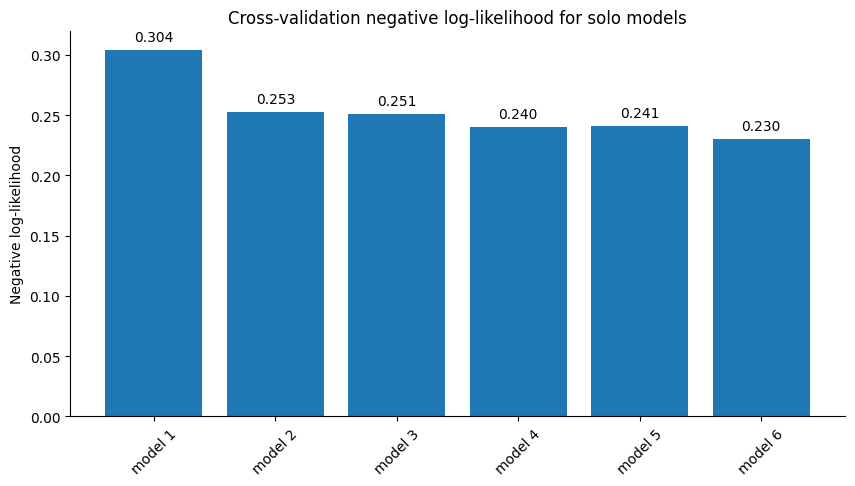

In [158]:
# plot nll barplot
plt.figure(figsize=(10, 5))
plt.bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')
plt.title('Cross-validation negative log-likelihood for solo models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Add values above bars
for i, value in enumerate(average_nlls):
    plt.text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# plt.tight_layout()

In [87]:
cross_validation_datasets[5]["model_formula"]

'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + D2H:FirstSeenWall + D2L:FirstSeenWall + FirstSeenWall:WallSep + (1|GlmPlayerID)'

In [89]:
# get prediction and ground truth data for each of the models in cross_validation_datasets
prediction_data = [cross_validation_datasets[i]['predictions'] for i in range(len(cross_validation_datasets))]
ground_truth_data = [cross_validation_datasets[i]['split_df'] for i in range(len(cross_validation_datasets))]


# concatenate across the folds to produce a single predictions and ground truth df for each model
for i, model_predictions in enumerate(prediction_data):
    prediction_data[i] = np.concatenate(model_predictions)

for i, model_ground_truth in enumerate(ground_truth_data):
    ground_truth_data[i] = np.concatenate(list(fold['ChooseHigh'].values for fold in model_ground_truth))




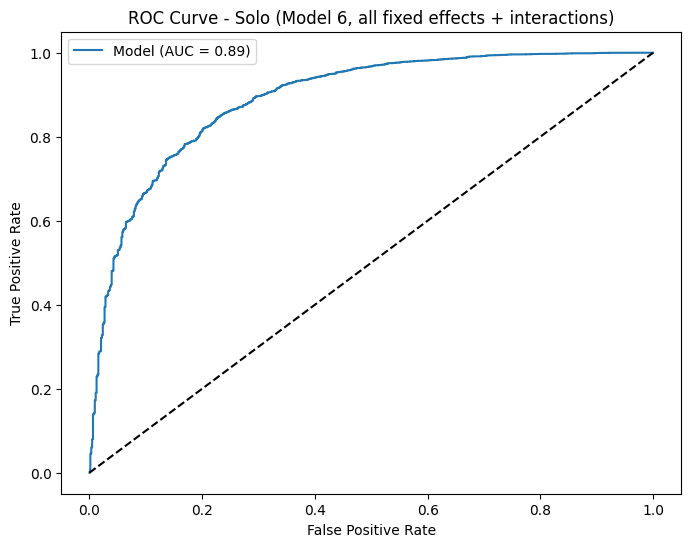

In [160]:
from sklearn.metrics import roc_curve, auc

# Example: Assuming `y_true` is the true labels and `y_scores` are model predictions
fpr, tpr, _ = roc_curve(ground_truth_data[5], prediction_data[5])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Solo (Model 6, all fixed effects + interactions)')
plt.legend()
plt.show()

## Solo-social

In [5]:
# load solo-social data from left-one-out cross-validation
data_folder = os.path.join('..','data', 'k_fold_CV')

CV_dataset_names = [
    file for file in os.listdir(data_folder) if file.startswith('20-fold-CV_results_solosocial') and file.endswith('.pickle')
]
print(CV_dataset_names)

# ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[2], CV_dataset_names[3], CV_dataset_names[4], CV_dataset_names[2]]
ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[1], CV_dataset_names[2], CV_dataset_names[3]]


print(ordered_datasets_names)


cross_validation_datasets = [pd.read_pickle(os.path.join(data_folder, file)) for file in ordered_datasets_names
]


['20-fold-CV_results_solosocial_randomintercepts.pickle', '20-fold-CV_results_solosocial_randomintercepts_plus-socialcontext.pickle', '20-fold-CV_results_solosocial_randomintercepts_plus-socialcontext_fsw-interactions.pickle', '20-fold-CV_results_solosocial_randomintercepts_plus-socialcontext_fsw-interactions_socialcontext-dist_interactions.pickle']
['20-fold-CV_results_solosocial_randomintercepts.pickle', '20-fold-CV_results_solosocial_randomintercepts_plus-socialcontext.pickle', '20-fold-CV_results_solosocial_randomintercepts_plus-socialcontext_fsw-interactions.pickle', '20-fold-CV_results_solosocial_randomintercepts_plus-socialcontext_fsw-interactions_socialcontext-dist_interactions.pickle']


In [6]:
# find k
k = len(cross_validation_datasets[0]['split_df'])
print(f"{k} folds")

20 folds


In [ ]:
# create plotting names
plotting_names = [
    'model 1',
    'model 2'
    'model 3',
    'model 4'
]

In [ ]:
# extract and process nll
nlls = [ dataset['nll'] for dataset in cross_validation_datasets]

# divide nll by the number of models
average_nlls = [dataset['average_nll'] for dataset in cross_validation_datasets]

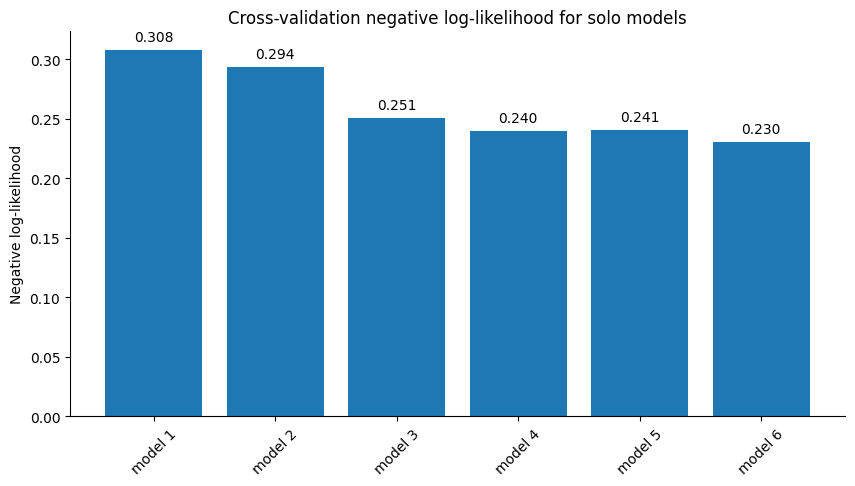

In [ ]:
# plot nll barplot
plt.figure(figsize=(10, 5))
plt.bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')
plt.title('Cross-validation negative log-likelihood for solo-social models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Add values above bars
for i, value in enumerate(average_nlls):
    plt.text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# plt.tight_layout()

In [ ]:
cross_validation_datasets[0]["model_formula"]

'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + D2H:FirstSeenWall + D2L:FirstSeenWall + FirstSeenWall:WallSep + (1|GlmPlayerID)'

In [ ]:
# get prediction and ground truth data for each of the models in cross_validation_datasets
prediction_data = [cross_validation_datasets[i]['predictions'] for i in range(len(cross_validation_datasets))]
ground_truth_data = [cross_validation_datasets[i]['split_df'] for i in range(len(cross_validation_datasets))]


# concatenate across the folds to produce a single predictions and ground truth df for each model
for i, model_predictions in enumerate(prediction_data):
    prediction_data[i] = np.concatenate(model_predictions)

for i, model_ground_truth in enumerate(ground_truth_data):
    ground_truth_data[i] = np.concatenate(list(fold['ChooseHigh'].values for fold in model_ground_truth))




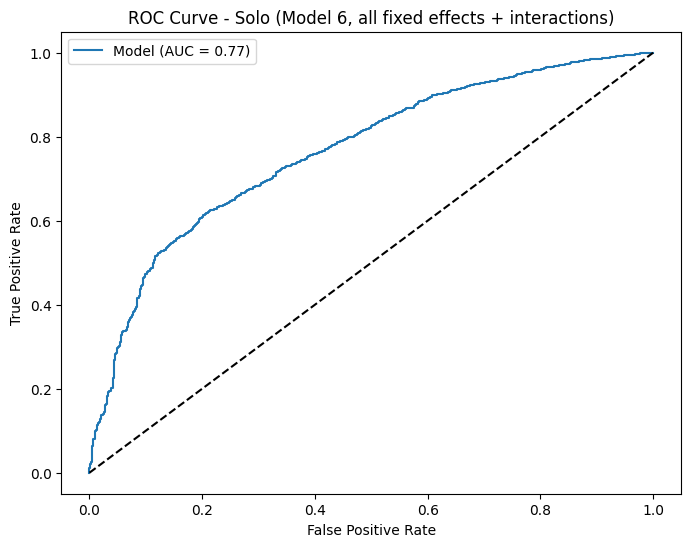

In [ ]:
from sklearn.metrics import roc_curve, auc

# Example: Assuming `y_true` is the true labels and `y_scores` are model predictions
fpr, tpr, _ = roc_curve(ground_truth_data[0], prediction_data[0])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Solo-Social (Model 6, all fixed effects + interactions)')
plt.legend()
plt.show()

## Social

In [ ]:
# load social data from left-one-out cross-validation
data_folder = os.path.join('..','data', 'k_fold_CV')

CV_dataset_names = [
    file for file in os.listdir(data_folder) if file.startswith('20-fold-CV_results_social') and file.endswith('.pickle')
]
print(CV_dataset_names)

# ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[2], CV_dataset_names[3], CV_dataset_names[4], CV_dataset_names[2]]
ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[1]]


print(ordered_datasets_names)


cross_validation_datasets = [pd.read_pickle(os.path.join(data_folder, file)) for file in ordered_datasets_names
]


['20-fold-CV_results_solo_randomintercepts.pickle', '20-fold-CV_results_solo_randomintercepts_distanceplusfirstseen.pickle', '20-fold-CV_results_solo_randomintercepts_distancepluswallsep.pickle', '20-fold-CV_results_solo_randomintercepts_distancesandwallsepinteraction.pickle', '20-fold-CV_results_solo_randomintercepts_onlydistance.pickle', '20-fold-CV_results_solo_randomintercepts_wallseponly.pickle', '20-fold-CV_results_solo_randomintercepts_wallsep_firstseen.pickle', '20-fold-CV_results_solo_randomintercepts__distancesinteraction.pickle']
['20-fold-CV_results_solo_randomintercepts_onlydistance.pickle', '20-fold-CV_results_solo_randomintercepts_distancepluswallsep.pickle', '20-fold-CV_results_solo_randomintercepts_distanceplusfirstseen.pickle', '20-fold-CV_results_solo_randomintercepts.pickle', '20-fold-CV_results_solo_randomintercepts__distancesinteraction.pickle', '20-fold-CV_results_solo_randomintercepts_distancesandwallsepinteraction.pickle']


In [ ]:
# find k
k = len(cross_validation_datasets[0]['split_df'])
print(f"{k} folds")

20 folds


In [ ]:
# create plotting names
plotting_names = [
    'model 1',
    'model 2'
]

In [ ]:
# extract and process nll
nlls = [ dataset['nll'] for dataset in cross_validation_datasets]

# divide nll by the number of models
average_nlls = [dataset['average_nll'] for dataset in cross_validation_datasets]

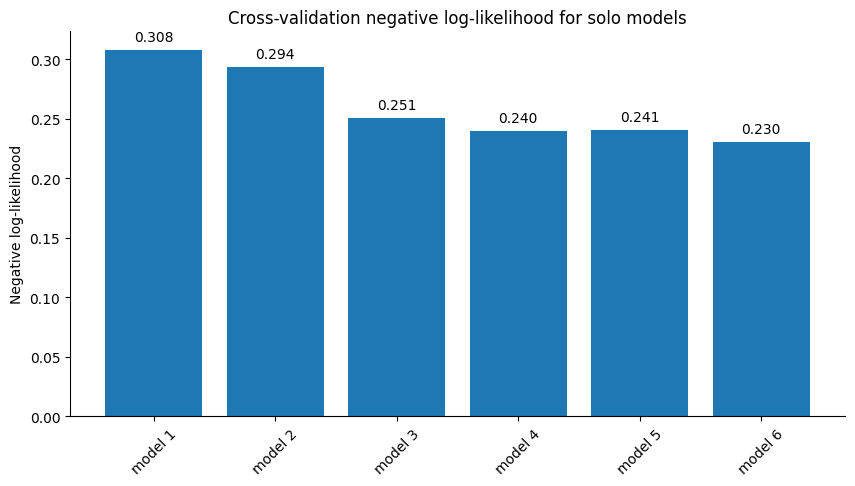

In [ ]:
# plot nll barplot
plt.figure(figsize=(10, 5))
plt.bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')
plt.title('Cross-validation negative log-likelihood for social models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Add values above bars
for i, value in enumerate(average_nlls):
    plt.text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# plt.tight_layout()

In [ ]:
cross_validation_datasets[0]["model_formula"]

'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + D2H:FirstSeenWall + D2L:FirstSeenWall + FirstSeenWall:WallSep + (1|GlmPlayerID)'

In [ ]:
# get prediction and ground truth data for each of the models in cross_validation_datasets
prediction_data = [cross_validation_datasets[i]['predictions'] for i in range(len(cross_validation_datasets))]
ground_truth_data = [cross_validation_datasets[i]['split_df'] for i in range(len(cross_validation_datasets))]


# concatenate across the folds to produce a single predictions and ground truth df for each model
for i, model_predictions in enumerate(prediction_data):
    prediction_data[i] = np.concatenate(model_predictions)

for i, model_ground_truth in enumerate(ground_truth_data):
    ground_truth_data[i] = np.concatenate(list(fold['ChooseHigh'].values for fold in model_ground_truth))




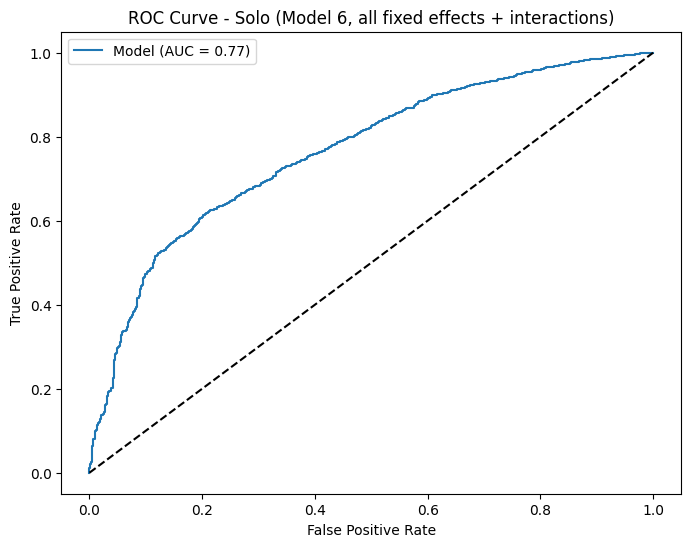

In [ ]:
from sklearn.metrics import roc_curve, auc

# Example: Assuming `y_true` is the true labels and `y_scores` are model predictions
fpr, tpr, _ = roc_curve(ground_truth_data[0], prediction_data[0])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Social (Model 6, all fixed effects + interactions)')
plt.legend()
plt.show()